Theodoros Kassa Aragie

251163893

ECE 9309

Prof. Soodeh Nikan

February 17, 2025

# Implementing Agglomerative Clustering for a Recommender System

Dataset 1: https://www.kaggle.com/datasets/pushkaranp/ieee-research-papers-dataset?resource=download

In [1]:
# Misc Imports
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# SciKit-Learn Imports
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler 
import scipy.cluster.hierarchy as shc 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Splitted Data, Normalize, Apply PCA

In [2]:
# Load in the preprocessed dataset splits
trnDF:pd.DataFrame = pd.read_parquet("./parquets/train.parquet.gzip")
tstDF:pd.DataFrame = pd.read_parquet("./parquets/test.parquet.gzip")
valDF:pd.DataFrame = pd.read_parquet("./parquets/val.parquet.gzip")
cleanedDF:pd.DataFrame = pd.read_parquet("./parquets/cleaned.parquet.gzip")

# Normalize the data
scaler = StandardScaler()
trnNorm:pd.DataFrame = pd.DataFrame(
    scaler.fit_transform(trnDF), columns=trnDF.columns
)
tstNorm:pd.DataFrame = pd.DataFrame(
    scaler.transform(tstDF), columns=tstDF.columns
)
valNorm:pd.DataFrame = pd.DataFrame(
    scaler.transform(valDF), columns=valDF.columns
)

# Apply PCA to reduce dimensionality to 2 features
pca:PCA = PCA(n_components=2).fit(trnNorm)
trnComp:pd.DataFrame = pd.DataFrame(
    pca.transform(trnNorm), columns=["P1", "P2"]
)
tstComp:pd.DataFrame = pd.DataFrame(
    pca.transform(tstNorm), columns=["P1", "P2"]
)
valComp:pd.DataFrame = pd.DataFrame(
    pca.transform(valNorm), columns=["P1", "P2"]
)

## Visualize Data and Determine the Best n_clusters for Agglomerative Clustering

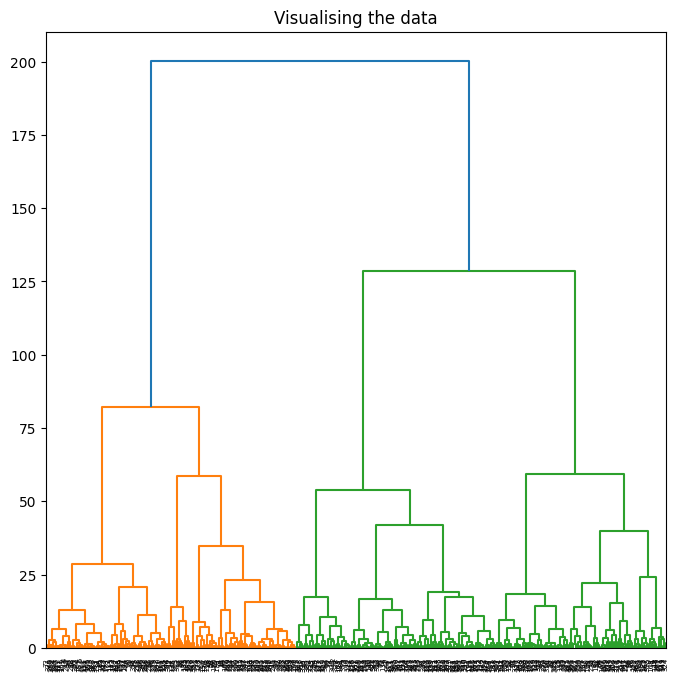

In [3]:
# Dendrogram
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(trnComp, method ='ward')))

[2, 3, 4, 5, 6]


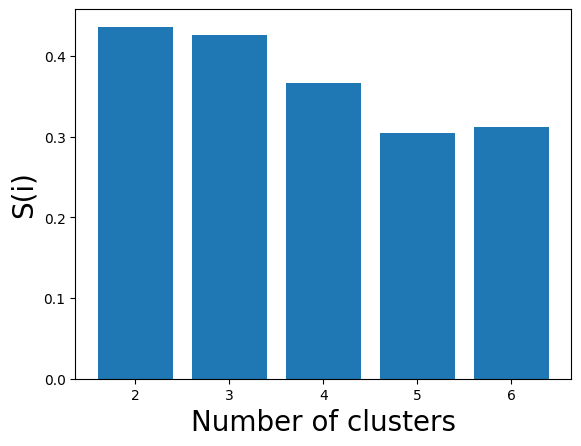

In [4]:
# Use silhouette scores to assess the best AC
# (AgglomerativeClustering) n_clusters value
kVals:list[int] = [i for i in range(2, 7)]
print(kVals)

silhScores:list = [
    silhouette_score(
        trnComp,
        AgglomerativeClustering(n_clusters=i).fit_predict(trnComp)
    ) for i in kVals
]

# Plotting a bar graph to compare the results 
plt.bar(kVals, silhScores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

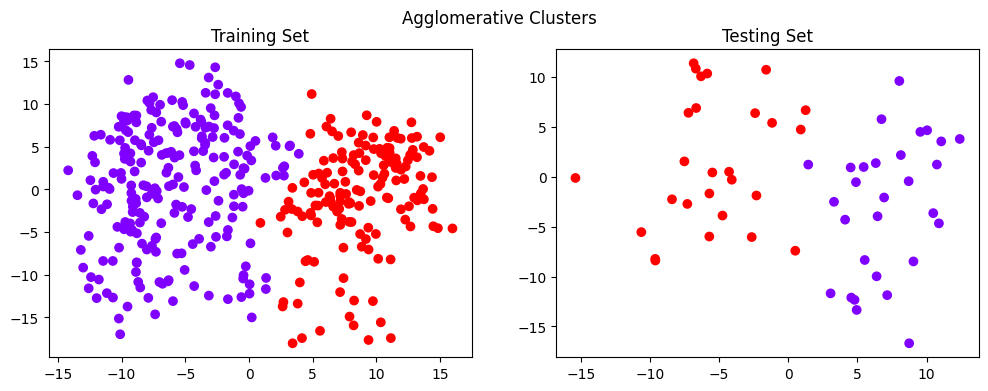

In [5]:
# Calculate labels using optimal AC clusters
bestAC:AgglomerativeClustering = AgglomerativeClustering(n_clusters=2)
trnLabels = bestAC.fit_predict(trnComp)
trnDF["cluster"] = trnLabels
tstLabels = bestAC.fit_predict(tstComp)
tstDF["cluster"] = tstLabels

# Plotting optimial AC clusters
plt.figure(figsize=(12, 4))
plt.suptitle("Agglomerative Clusters")
plt.subplot(1, 2, 1)
plt.scatter(
    trnComp['P1'], trnComp['P2'], 
    c = trnLabels,
    cmap ='rainbow'
)
plt.title("Training Set")
plt.subplot(1, 2, 2)
plt.scatter(
    tstComp['P1'], tstComp['P2'], 
    c = tstLabels,
    cmap ='rainbow'
)
plt.title("Testing Set")
plt.show()

## Make Recomendations, Cosine Similarity, Save Model

In [6]:
# Function to recommend top n papers (default to top_n=10)
def recommendPapers(testPaperIndex:int, top_n:int=10):
    testPaperClusters:pd.DataFrame = tstDF.iloc[
        testPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == testPaperClusters
    ]
    # Ensure index alignment before selecting PCA-reduced embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnComp.index
    )
    # Get PCA-reduced vectors (Ensure both use PCA-reduced data)
    testEmbeddings:npt.NDArray = tstComp.iloc[
        testPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnComp.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute the distances between points
    distances:npt.NDArray = euclidean_distances(testEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnComp.iloc[topIndices].values
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        testEmbeddings, topEmbeddings
    ) 
    return similarities, topPapers

# Example usage
testSims, topRecommendations = recommendPapers(0, top_n=10)
print(cleanedDF.iloc[topRecommendations])

     Unnamed: 0   Id                                              title  \
22           22   22  Development of a Multi-Dimensional Parametric ...   
214         214  214  Performance Analysis of Long Short-Term Memory...   
226         226  226  LinRegDroid: Detection of Android Malware Usin...   
248         248  248  Robust Deep Learning-Based Driver Distraction ...   
285         285  285  Making Connected Cars Untraceable via DSRC Radios   
340         340  340  Security of Vehicle Platooning: A Game-Theoret...   
371         371  371  Subjective Answers Evaluation Using Machine Le...   
380         380  380  Tumor Depth and Size Perception Using a Pneuma...   
386         386  386  Path Planning Algorithm Using the Hybridizatio...   
393         393  393  Achieving Privacy-Preserving Subset Aggregatio...   

                   link  year  \
22   /document/9294079/  2020   
214  /document/9605607/  2021   
226  /document/9694615/  2022   
248  /document/9641850/  2021   
285  /doc

In [7]:
# Compute average similarity score per test sample
avgTestScore:npt.NDArray = testSims.mean(axis=1)

# Overall similarity score
avgTestSim:npt.NDArray = avgTestScore.mean()
print(f"\nAverage Cosine Similarity Score for Test Set: {avgTestSim}")

# Save the trained model
joblib.dump(bestAC, "./dump/acModel.pkl")


Average Cosine Similarity Score for Test Set: -0.35080425918347313


['./dump/acModel.pkl']

In [8]:
# Reload the model
loadedModel:AgglomerativeClustering = joblib.load("./dump/acModel.pkl")
valLabels = loadedModel.fit_predict(valComp)
valDF["cluster"] = valLabels

In [9]:
# Function to recommend top n papers (default to top_n=10)
def selectPapers(valPaperIndex:int, top_n:int=10):
    valPaperClusters:pd.DataFrame = valDF.iloc[
        valPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == valPaperClusters
    ]
    # Ensure index alignment before selecting PCA-reduced embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnComp.index
    )
    # Get PCA-reduced vectors (Ensure both use PCA-reduced data)
    valEmbeddings:npt.NDArray = valComp.iloc[
        valPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnComp.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute the distances between points
    distances:npt.NDArray = euclidean_distances(valEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnComp.iloc[topIndices].values
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        valEmbeddings, topEmbeddings
    ) 
    return similarities, topPapers

# Test on new papers
valSims, topSelections = selectPapers(0, top_n=10)
print(cleanedDF.iloc[topSelections])

# Compute average similarity score per validation sample
avgValScore:npt.NDArray = valSims.mean(axis=1)

# Overall similarity score
avgValSim:npt.NDArray = avgValScore.mean()
print(f"\nAverage Cosine Similarity Score for Validation Set: {avgValSim}")

     Unnamed: 0   Id                                              title  \
23           23   23  Credit-Based Distributed Real-Time Energy Stor...   
137         137  137  Development of Smart Battery Cell Monitoring S...   
147         147  147  Linear Quadratic Tracking With Reinforcement L...   
148         148  148  Artificial Intelligence Vision-Based Monitorin...   
228         228  228  Direct Drop-on-Demand Printing of Molten Solde...   
278         278  278  A Hybrid Reinforcement Learning-Based Model fo...   
283         283  283  Investigation of DNN-HMM and Lattice Free Maxi...   
297         297  297  In-situ Measurement Methodology for the Assess...   
320         320  320  Design Guidelines for Mammogram-Based Computer...   
386         386  386  Path Planning Algorithm Using the Hybridizatio...   

                   link  year  \
23   /document/8938754/  2019   
137  /document/9288786/  2020   
147  /document/9645562/  2021   
148  /document/9296755/  2020   
228  /doc

## TF-IDF and Feature Importance Plot

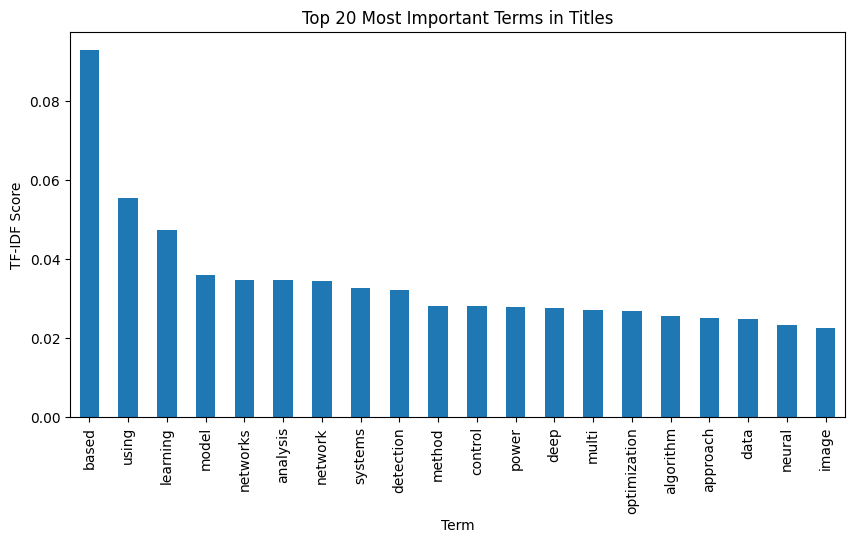

In [10]:
# Convert titles into TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(cleanedDF["title"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

# Plot top 20 TF-IDF terms
tfidf_df.mean().nlargest(20).plot(kind='bar', figsize=(10, 5))
plt.title("Top 20 Most Important Terms in Titles")
plt.xlabel("Term")
plt.ylabel("TF-IDF Score")
plt.show()